In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import json
import math
import time
import numpy as np
import scipy
import scipy.linalg
import random
import gc
import PIL
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output

import pickle
from torch.utils import data

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 2.0
# import seaborn as sns
# sns.set()

# from tqdm.notebook import tqdm
from tqdm import tqdm


from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Subset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import transforms

from functools import lru_cache


<ipython-input-1-dda8e3ffe30e>:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

    torch.backends.cudnn.benchmark = True # as we will resize the images
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = True


SEED=42
seed_everything(SEED=SEED)

In [ ]:
dir_path = '/content/change_tiktok_00_01'

In [ ]:
import tarfile
import os
import shutil

def extract_tarfile(tar_path, extract_path):
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(path=extract_path)


pathes = ["/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/tiktok-00000000.tar",
                     "/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/data/tiktok-00000001.tar"
                     ]  # Path to the original .tar file

# pathes = ['/content/drive/MyDrive/tiktok-00000000.tar',
        #   '/content/drive/MyDrive/tiktok-00000001.tar']
extract_path = dir_path     # Directory to extract files to

# Step 1: Extract the contents of the .tar file
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

for original_tar_path in pathes:
    extract_tarfile(original_tar_path, extract_path)

In [ ]:
from collections import defaultdict

any_order_files = os.listdir(dir_path)

label_dict = defaultdict(lambda: [0] * 10)
texts = []
c = 0
for i, name in enumerate(any_order_files):
    if name.endswith('.jpg'):
        frame_id = int(name.split('.')[1][-1])
        # label = name.split('_')[1].split('.')[0].strip()
        vid_id = name.split('_')[0].strip()

        label_dict[vid_id][frame_id] = name

texts = []
for vid_id, frames in label_dict.items():
    texts.append(frames[0].split('_')[1].split('.')[0].strip())

In [ ]:
len(label_dict), len(texts)

(200, 200)

In [ ]:
!pip install -q open_clip_torch
!pip install -q multilingual-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 163.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 72.8 MB/s eta 0:00:00


In [ ]:
import torch
from PIL import Image
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
# tokenizer = open_clip.get_tokenizer('ViT-L-14')

100%|███████████████████████████████████████| 933M/933M [00:23<00:00, 39.7MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwise_affine=Tru

In [ ]:
from multilingual_clip import pt_multilingual_clip
import transformers

model_name = 'M-CLIP/XLM-Roberta-Large-Vit-L-14'

# Load Model & Tokenizer
text_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
model = model.to(device)
text_model = text_model.to('cpu')

In [ ]:
def get_text_features(texts: list[str], target_class_name: str='cake', save=True) -> list[torch.Tensor, torch.Tensor]:

    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = text_model(texts, tokenizer)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        cake_emb = text_model.forward([target_class_name], tokenizer)
        cake_emb /= cake_emb.norm(dim=-1, keepdim=True)

        text_features = text_features.to(device)
        cake_emb = cake_emb.to(device)

        if save:
            torch.save(text_features, 'text_features.pt')

    return text_features, cake_emb

In [ ]:
text_features, cake_emb = get_text_features(texts)

In [ ]:
def patch_forward(patch: torch.Tensor):
    # Ensure patch is on the correct device
#     patch = patch.to(device)
    patch = F.sigmoid(patch)  # from [-infty, infty] to [0, 1]

    return patch

In [ ]:
my_preprocess = transforms.Compose([
    preprocess.transforms[0],
    preprocess.transforms[1],
    preprocess.transforms[-1],
])

In [ ]:
def simple_place_patch(imgs: list[torch.Tensor],
                patch: torch.Tensor,
                place_patch_: list[bool],
                get_clean=True,
               ) -> tuple[torch.Tensor, ]:

    batch_size = len(imgs)

    imgs_clean = []
    imgs_adv = []

    for frame_id in range(len(imgs)):
        gc.collect()
        torch.cuda.empty_cache()

        img_i = imgs[frame_id].clone()

        # save clean images for further results based on them
        if get_clean:
            imgs_clean.append(my_preprocess(img_i.detach().clone()))

        if place_patch_[frame_id]:
            # Apply the patch using precomputed offsets
            h_offset = np.random.randint(0, img_i.shape[-2] - patch.shape[1] - 1)
            w_offset = np.random.randint(0, img_i.shape[-1] - patch.shape[2] - 1)

            img_i[:, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]] = patch_forward(patch)

        # apply preprocessing
        imgs_adv.append(my_preprocess(img_i))

    # now images have the same size so we can stack them in one tensor
    imgs_stack = torch.stack(imgs_adv, dim=0)

    if get_clean:
        imgs_clean = torch.stack(imgs_clean, dim=0)

        return imgs_stack, imgs_clean

    return imgs_stack,


In [ ]:
patch = torch.load('/content/drive/MyDrive/Colab_Notebooks/CV/papers/attacks_on_CLIP/patch-data/25_(64, 64)_epoch_5_ViT-L-14_patch_imgs_10203.pt')
# patch = torch.load('/content/drive/MyDrive/25_(64, 64)_epoch_5_ViT-L-14_patch_imgs_10203.pt')

In [ ]:
import numpy as np
from tqdm.notebook import tqdm


def get_adv_mask(clean_image_features, text_feature, topk):
    if topk == len(clean_image_features):
        return torch.ones(len(clean_image_features), dtype=torch.bool).tolist()
    elif topk == 0:
        return torch.zeros(len(clean_image_features), dtype=torch.bool).tolist()

    clean_image_features /= clean_image_features.norm(dim=-1, keepdim=True)  # shape of clean features is [num_frames, ...]
    scores = (100.0 * clean_image_features @ text_feature.T).view(-1)
    adv_ids = torch.topk(scores, topk).indices

    adv_mask = torch.zeros(len(clean_image_features), dtype=torch.bool)
    adv_mask[adv_ids] = True

    return adv_mask.tolist()


def calc_asr(topk=None, adv_mask: list[bool]=None):
    metrics = []
    adv_masks = 0

    for i, (label, (vid_id, frames)) in tqdm(enumerate(zip(texts, label_dict.items())), total=len(label_dict), leave=False):
        torch_imgs = [transforms.ToTensor()(Image.open(os.path.join(dir_path, frame))) for frame in frames]

        text_feature = text_features[i].unsqueeze(0)

        with torch.no_grad(), torch.cuda.amp.autocast():
            clean_imgs = torch.stack([my_preprocess(img_i.detach().clone()).to(device) for img_i in torch_imgs], dim=0)
            clean_image_features = model.encode_image(clean_imgs)

            if topk is not None:
                adv_mask = get_adv_mask(clean_image_features, text_feature, topk)
                adv_masks += np.array(adv_mask, dtype=int)
                if topk in list(range(8)):
                  continue

            adv_imgs, *_ = simple_place_patch(torch_imgs, patch, adv_mask, get_clean=False)
            adv_image_features = model.encode_image(adv_imgs.to(device))

            adv_feature = torch.mean(adv_image_features, dim=0).unsqueeze(0)
            clean_feature = torch.mean(clean_image_features, dim=0).unsqueeze(0)

            adv_feature /= adv_feature.norm(dim=-1, keepdim=True)
            clean_feature /= clean_feature.norm(dim=-1, keepdim=True)

            adv_p = (100.0 * adv_feature @ cake_emb.T).item()
            clean_p = (100.0 * clean_feature @ text_feature.T).item()
            conf_pi = (100.0 * clean_feature @ cake_emb.T).item()
            conf_pt = (100.0 * adv_feature @ text_feature.T).item()

            metrics.append([adv_p, clean_p, conf_pi, conf_pt])

    metrics = np.array(metrics)
    np.save(f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/metrics_data/calc_masks/metrics_{sum(adv_mask)}.npy', metrics)
    # np.save(f'/content/metrics_{sum(adv_mask)}.npy', metrics)

    # np.save(f'/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/adv_mask_{sum(adv_mask)}.npy', adv_masks)

    if topk is not None:
        return adv_masks

In [ ]:
pps = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 10
    [1, 0, 1, 1, 0, 1, 1, 0, 1, 1],  # 7
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],  # 5
    [0, 0, 1, 0, 0, 1, 0, 0, 1, 0],  # 3
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # 1
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 0
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 9
    [0, 1, 1, 1, 1, 1, 1, 1, 0, 1],  # 8
    [1, 0, 1, 0, 1, 1, 1, 0, 1, 0],  # 6
    [0, 0, 1, 0, 1, 0, 1, 0, 1, 0],  # 4
    [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],  # 2
       ]

In [ ]:
# for place_patch_ in tqdm(pps):
    # calc_asr(place_patch_)

all_masks = []

for topk in tqdm(range(11)):
    adv_masks = calc_asr(topk)
    all_masks.append(adv_masks)


np.save('/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/metrics_data/calc_masks/all_masks.npy', all_masks)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
dir_path = '/content/drive/MyDrive/Colab_Notebooks/CV/papers/data/HSE_Project_attacks/metrics_data/calc_masks/tiktok/'
m_pathes = sorted(os.listdir(dir_path), key=lambda x: int(x.split("_")[1].split(".")[0]) if 'metrics' in x else float("inf"))[:-1]
m_pathes

['metrics_0.npy',
 'metrics_1.npy',
 'metrics_2.npy',
 'metrics_3.npy',
 'metrics_4.npy',
 'metrics_5.npy',
 'metrics_6.npy',
 'metrics_7.npy',
 'metrics_8.npy',
 'metrics_9.npy',
 'metrics_10.npy']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_scores(metrics, N, show_quant=True):
    adv_p, clean_p, conf_pi, conf_pt = metrics[:, 0], metrics[:, 1], metrics[:, 2], metrics[:, 3]

    # Convert RGB to hexadecimal
    def rgb_to_hex(rgb):
        return '#{:02x}{:02x}{:02x}'.format(*rgb)

    # Additional color groups for this plot
    color_adv_p = rgb_to_hex((230, 30, 60))     # From Group 4
    color_clean_p = rgb_to_hex((15, 160, 215))   # From Group 1
    color_conf_pi = rgb_to_hex((0, 155, 100))  # From Group 4
    color_conf_pt = rgb_to_hex((125, 80, 185))    # From Group 2

    # Gray shades
    gray_50 = rgb_to_hex((128, 128, 128))  # Approximation for C0 M0 Y0 K50
    gray_25 = rgb_to_hex((191, 191, 191))  # Approximation for C0 M0 Y0 K25
    gray_10 = rgb_to_hex((230, 230, 230))  # Approximation for C0 M0 Y0 K10

    # Example data
    img_id = range(len(metrics))

    plt.figure(figsize=(10, 5))
    plt.plot(img_id, adv_p, color=color_adv_p, label='adv_p')
    plt.plot(img_id, clean_p, color=color_clean_p, label='clean_p')
    plt.plot(img_id, conf_pi, color=color_conf_pi, label='conf_pi')
    plt.plot(img_id, conf_pt, color=color_conf_pt, label='conf_pt')

    plt.legend(prop={'size': 10}, fancybox=True, framealpha=0.9, edgecolor=gray_50)

    plt.grid(axis='y', linestyle='--', alpha=0.7, color=gray_25)

    plt.xlabel('Image ID', fontsize=15, fontweight='bold', color=gray_50, labelpad=15)
    plt.ylabel('CLIP score', fontsize=15, fontweight='bold', color=gray_50, labelpad=15)
    plt.title(f'Adversarial and Clean CLIP scores\n{N / 10 * 100}% adv', fontsize=20, fontweight='bold', color=gray_50, pad=20)

    # Customize spines
    ax = plt.gca()
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # Background color
    # ax.set_facecolor(gray_10)
    plt.tight_layout(pad=2)

    plt.show()

    if show_quant:
        print(f'{N / 10 * 100}% adv imgs in each video')
        asr = sum(adv_p > clean_p) / len(adv_p)
        print(f"Adversarial success rate clear and adv: {asr:.2f}")

        asr_pt = sum(adv_p > conf_pt) / len(adv_p)
        print(f"Adversarial success rate for only adv vids: {asr_pt:.2f}")



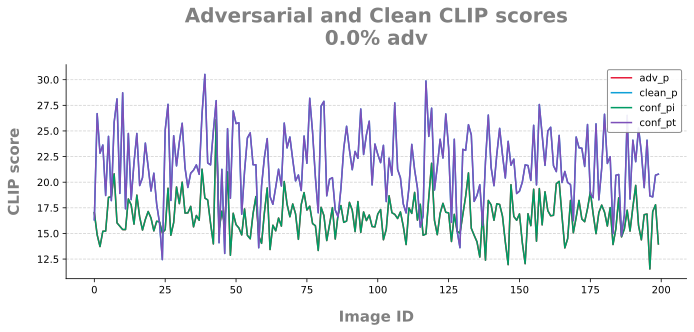

0.0% adv imgs in each video
Adversarial success rate clear and adv: 0.06
Adversarial success rate for only adv vids: 0.06


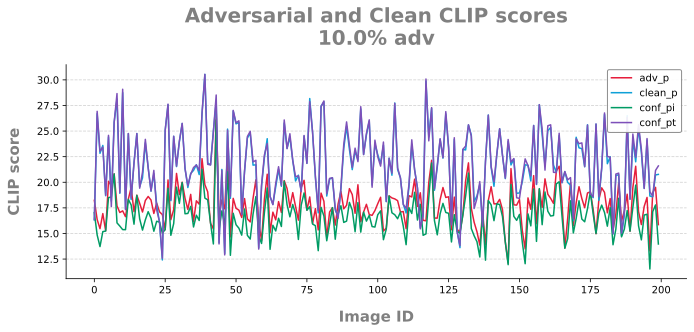

10.0% adv imgs in each video
Adversarial success rate clear and adv: 0.12
Adversarial success rate for only adv vids: 0.10


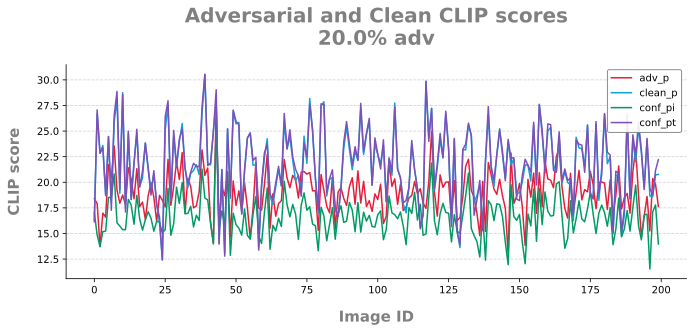

20.0% adv imgs in each video
Adversarial success rate clear and adv: 0.21
Adversarial success rate for only adv vids: 0.20


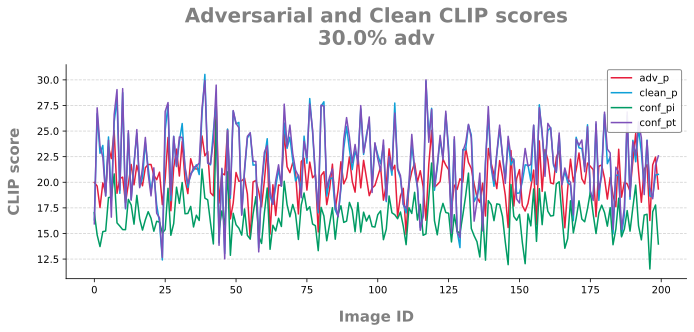

30.0% adv imgs in each video
Adversarial success rate clear and adv: 0.34
Adversarial success rate for only adv vids: 0.33


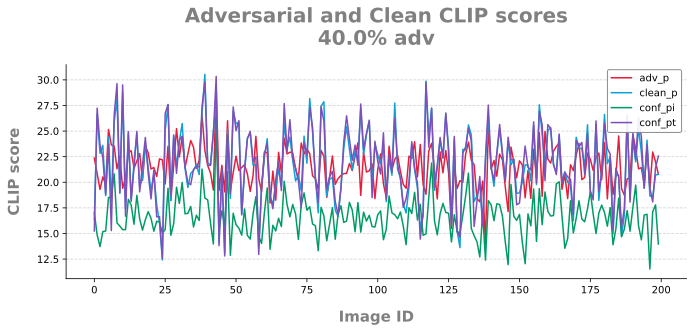

40.0% adv imgs in each video
Adversarial success rate clear and adv: 0.47
Adversarial success rate for only adv vids: 0.44


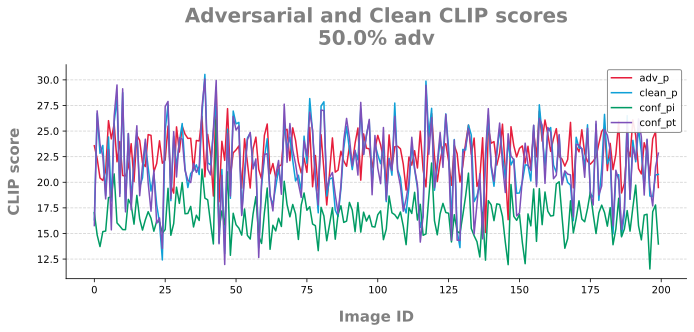

50.0% adv imgs in each video
Adversarial success rate clear and adv: 0.62
Adversarial success rate for only adv vids: 0.62


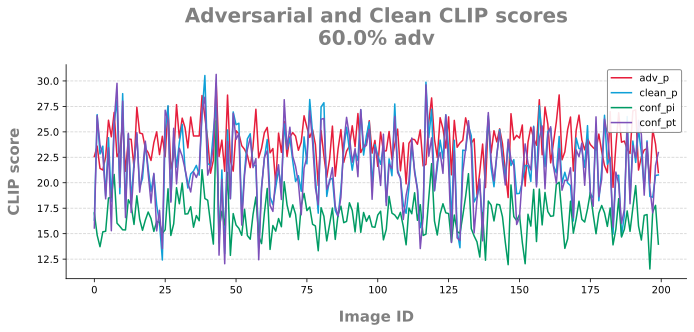

60.0% adv imgs in each video
Adversarial success rate clear and adv: 0.76
Adversarial success rate for only adv vids: 0.75


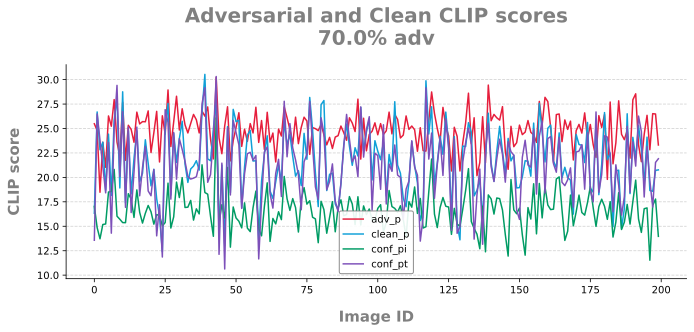

70.0% adv imgs in each video
Adversarial success rate clear and adv: 0.82
Adversarial success rate for only adv vids: 0.84


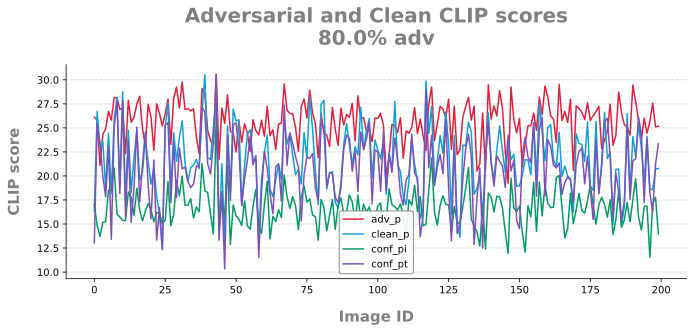

80.0% adv imgs in each video
Adversarial success rate clear and adv: 0.89
Adversarial success rate for only adv vids: 0.90


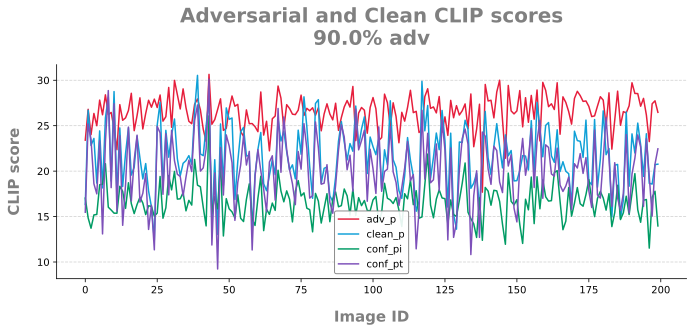

90.0% adv imgs in each video
Adversarial success rate clear and adv: 0.91
Adversarial success rate for only adv vids: 0.94


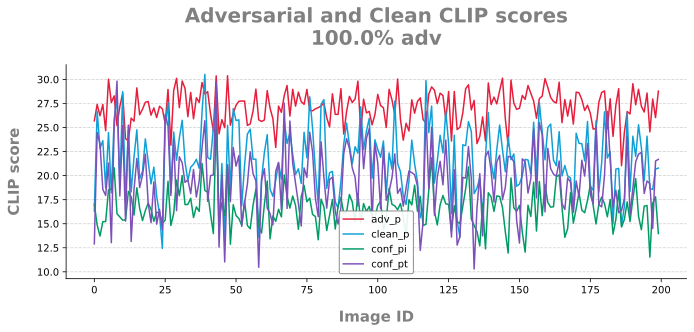

100.0% adv imgs in each video
Adversarial success rate clear and adv: 0.93
Adversarial success rate for only adv vids: 0.96


In [ ]:
for m_path in m_pathes:
    N = int(m_path.split("_")[-1].split(".")[0])
    metrics = np.load(dir_path + m_path)  # [adv_p, clean_p, conf_pi, conf_pt]

    plot_scores(metrics, N)

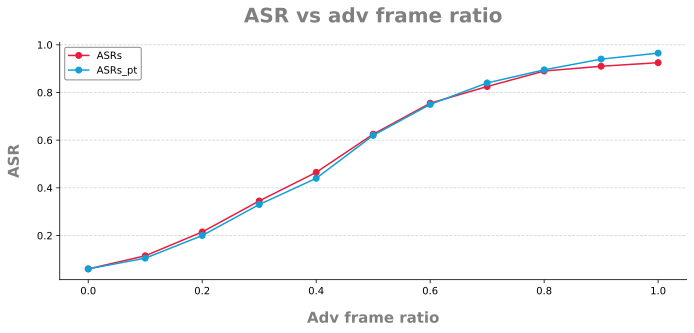

In [ ]:
perces = []
asrs, asrs_pt = [], []

for m_path in m_pathes:
    N = int(m_path.split("_")[-1].split(".")[0])
    metrics = np.load(dir_path + m_path)  # [adv_p, clean_p, conf_pi, conf_pt]

    adv_p, clean_p, conf_pi, conf_pt = metrics[:, 0], metrics[:, 1], metrics[:, 2], metrics[:, 3]

    perc = N / 10
    asr = sum(adv_p > clean_p) / len(adv_p)
    asr_pt = sum(adv_p > conf_pt) / len(adv_p)

    asrs.append(asr)
    asrs_pt.append(asr_pt)
    perces.append(perc)

# Convert RGB to hexadecimal
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

# Additional color groups for this plot
color_asrs = rgb_to_hex((230, 30, 60))     # From Group 4
color_asrs_pt = rgb_to_hex((15, 160, 215))   # From Group 1
# color_conf_pi = rgb_to_hex((0, 155, 100))  # From Group 4
# color_conf_pt = rgb_to_hex((125, 80, 185))    # From Group 2

# Gray shades
gray_50 = rgb_to_hex((128, 128, 128))  # Approximation for C0 M0 Y0 K50
gray_25 = rgb_to_hex((191, 191, 191))  # Approximation for C0 M0 Y0 K25
gray_10 = rgb_to_hex((230, 230, 230))  # Approximation for C0 M0 Y0 K10

# Example data
img_id = range(100)

plt.figure(figsize=(10, 5))
plt.plot(perces, asrs, '-o', color=color_asrs, label='ASRs')
plt.plot(perces, asrs_pt, '-o', color=color_asrs_pt, label='ASRs_pt')

plt.legend(prop={'size': 10}, fancybox=True, framealpha=0.9, edgecolor=gray_50)

plt.grid(axis='y', linestyle='--', alpha=0.7, color=gray_25)

plt.xlabel('Adv frame ratio', fontsize=15, fontweight='bold', color=gray_50, labelpad=15)
plt.ylabel('ASR', fontsize=15, fontweight='bold', color=gray_50, labelpad=15)
plt.title(f'ASR vs adv frame ratio', fontsize=20, fontweight='bold', color=gray_50, pad=20)

# Customize spines
ax = plt.gca()
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Background color
# ax.set_facecolor(gray_10)
plt.tight_layout(pad=2)

# plt.show()
plt.savefig("asrs_tiktok_00_01.png", bbox_inches="tight")

In [ ]:
all_masks = np.load(dir_path + "all_masks.npy")

In [ ]:
def plot_masks(all_masks):
    # Define the color palette
    dark_blue = '#0F2D69'
    light_blue = '#374B9B'
    gray_50 = '#7F7F7F'
    gray_25 = '#BFBFBF'
    gray_10 = '#E6E6E6'

    # Neon accent color group (choose one group)
    # Group 4 (Red shades)
    neon_colors = ['#E61E3C', '#CD5A5A', '#F5C3C3']  # Use up to 3 shades from one group

    # Create the plot with dark background
    plt.figure(figsize=(8, 8))
    plt.imshow(all_masks, cmap='coolwarm', interpolation='nearest')

    # Set the background color of the plot
    plt.gca().set_facecolor(dark_blue)

    # Add colorbar with neon shades
    colorbar = plt.colorbar()
    # colorbar.set_ticks([])  # Remove ticks from colorbar
    colorbar.outline.set_edgecolor(light_blue)  # Outline color of the colorbar
    colorbar.set_label('adv frame activation', fontweight='bold', fontsize=15, color=gray_50, labelpad=15)  # Set the labels of the neon shades


    # Customize colorbar using the neon palette
    # for i, tick in enumerate(colorbar.ax.get_yticklabels()):
    #     tick.set_color(neon_colors[i % len(neon_colors)])

    # Add text annotations for each cell in neon colors
    for i in range(all_masks.shape[0]):
        for j in range(all_masks.shape[1]):
            plt.text(j, i, all_masks[i, j], ha='center', va='center', color=light_blue, fontweight='bold')

    # Remove axis labels
    plt.xticks(range(len(all_masks[0])))
    plt.yticks(range(len(all_masks)))

    # Show the plot
    # plt.show()
    plt.xlabel('frame id', fontweight='bold', fontsize=15, color=gray_50, labelpad=15)
    plt.ylabel('Adv frame percentage', fontweight='bold', fontsize=15, color=gray_50, labelpad=15)
    plt.savefig("all_masks_dzen.png", bbox_inches="tight")

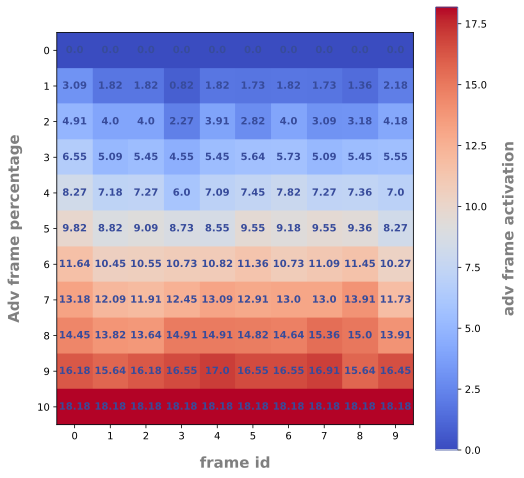

In [ ]:
adv_all_masks = np.array([np.round(mask / len(all_masks), 2) for mask in all_masks])

# plot_masks(np.array(all_masks))
plot_masks(adv_all_masks)